In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
import ipynb.fs.full.utils as utils
import ipynb.fs.full.features as features

df_train = pd.read_csv('./data/train.csv')
# Para usarse con el submit a Kaggle
df_test = pd.read_csv('./data/test.csv')

df_train = features.llenar_nulls(df_train)
df_test = features.llenar_nulls(df_test, hgb_mean=True, df_fill=df_train)

# df_train, df_test = features_de_csvs(df_train, df_test)

df_train, df_test = utils.dividir_df_testeo(df_train, test_size=0.2)

In [2]:
df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', df_aux=df_test_f)


df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

[14.0, 65.0, 84.0, 105.0, 130.0, 160.0, 190.0, 227.0, 275.0, 337.0, 440.0]

[-1.0, 0.0, 5.0, 8.11611392501718, 10.0, 81.0]

[14.0, 65.0, 85.0, 105.0, 131.0, 160.0, 190.0, 228.0, 273.0, 336.0, 440.0]

[-1.0, 0.0, 5.0, 8.11611392501718, 10.0, 81.0]

In [3]:
from sklearn.model_selection import train_test_split

class LightGBMWrapper(lgb.LGBMRegressor):
    
    def fit(self, x, y):        
        x_train, x_test, y_train, y_test = train_test_split(x, y)
        return super(LightGBMWrapper, self).fit(x_train, y_train)
    
    def predict(self, X):
        return super(LightGBMWrapper, self).predict(X, 
               num_iteration=self.best_iteration_)

hps = {'bagging_fraction': 0.806451877022587,
 'bagging_freq': 62.0,
 'feature_fraction': 0.5379925983440028,
 'learning_rate': 0.1363027714646826,
 'max_depth': 11.0,
 'num_leaves': 113.0,
 'test_size': 0.09575190901892519}

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae', # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': int(hps['num_leaves']),
    'learning_rate': hps['learning_rate'],
    'feature_fraction': hps['feature_fraction'],
    'bagging_fraction': hps['bagging_fraction'],
    'bagging_freq': int(hps['bagging_freq']),
    'max_depth': int(hps['max_depth']),
    'verbose': 0
}

lgb_m = LightGBMWrapper(**params)

## SelectKBest

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio', 'metrostotales_log', 'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros', 'escomercial', 'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad', 'tipo_propiedad_compartida', 'prop_frecuente', 'top_provincia', 'es_ciudad_centrica', 'promedio_metros_totales_provincia', 'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia', 'trimestre', 'dias_desde_datos', 'meses_desde_datos', 'delincuencia', 'turismo', 'es_antigua', 'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados', 'metros_cubiertos_normalizados', 'promedio_precio_provincia', 'promedio_precio_ciudad', 'promedio_precio_ciudad_gen', 'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona', 'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad', 'promedio_precio_tipo_propiedad_ciudad', 'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes', 'promedio_precio_habitaciones', 'promedio_precio_habitaciones_banos_garages', 'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad', 'promedio_precio_hbg_tipo_propiedad_provincia', 'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje', 'tipodepropiedad_Apartamento', 'tipodepropiedad_Bodega comercial', 'tipodepropiedad_Casa', 'tipodepropiedad_Casa en condominio', 'tipodepropiedad_Casa uso de suelo', 'tipodepropiedad_Departamento Compartido', 'tipodepropiedad_Duplex', 'tipodepropiedad_Edificio', 'tipodepropiedad_Inmuebles productivos urbanos', 'tipodepropiedad_Local Comercial', 'tipodepropiedad_Local en centro comercial', 'tipodepropiedad_Oficina comercial', 'tipodepropiedad_Otros', 'tipodepropiedad_Quinta Vacacional', 'tipodepropiedad_Rancho', 'tipodepropiedad_Terreno', 'tipodepropiedad_Terreno comercial', 'tipodepropiedad_Villa', 'tipodepropiedad_otro', 'provincia_Aguascalientes', 'provincia_Baja California Norte', 'provincia_Baja California Sur', 'provincia_Campeche', 'provincia_Chiapas', 'provincia_Chihuahua', 'provincia_Coahuila', 'provincia_Colima', 'provincia_Distrito Federal', 'provincia_Durango', 'provincia_Edo. de Mxico', 'provincia_Guanajuato', 'provincia_Guerrero', 'provincia_Hidalgo', 'provincia_Jalisco', 'provincia_Michoacn', 'provincia_Morelos', 'provincia_Nayarit', 'provincia_Nuevo Len', 'provincia_Oaxaca', 'provincia_Puebla', 'provincia_Quertaro', 'provincia_Quintana Roo', 'provincia_San luis Potos', 'provincia_Sinaloa', 'provincia_Sonora', 'provincia_Tabasco', 'provincia_Tamaulipas', 'provincia_Tlaxcala', 'provincia_Veracruz', 'provincia_Yucatn', 'provincia_otro', 'zona_Centro', 'zona_Norte ', 'zona_Sur'] 

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=0.001)

selector_kbest = SelectKBest(f_regression, k=30)
selector_kbest.fit_transform(x_train, y_train)
x_train.columns[selector_kbest.get_support()]

Index(['habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
       'metrostotales_log', 'metroscubiertos_log', 'top_provincia',
       'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'promedio_precio_ciudad_gen',
       'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona',
       'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'promedio_precio_hbg_tipo_propiedad_provincia', 'puntaje',
       'provincia_Distrito Federal'],
      dtype='object')

In [7]:
# Me mata la RAM, SWAP y me deja triste
# x_train_g = SelectKBest(mutual_info_regression, k=20).fit_transform(x_train_f, y_train)

## SelectFromModel

In [21]:
from sklearn.feature_selection import SelectFromModel

lgb_m = LightGBMWrapper(**params)
lgb_m.fit(x_train, y_train)

model = SelectFromModel(lgb_m, prefit=True)
x_train.columns[model.get_support()]

Index(['antiguedad', 'metroscubiertos', 'metrostotales', 'lat', 'lng',
       'metrostotales_log', 'metroscubiertos_log', 'porcentaje_metros',
       'diferencia_metros', 'promedio_metros_tipo_propiedad',
       'promedio_metros_cub_tipo_propiedad',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'dias_desde_datos',
       'meses_desde_datos', 'tam_ambientes', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'promedio_precio_ciudad',
       'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona',
       'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'promedio_precio_hbg_tipo_propiedad_provincia', 'la

In [25]:
from sklearn.feature_selection import SelectFromModel

features_sub = ['antiguedad', 'metroscubiertos', 'metrostotales', 
       'porcentaje_metros', 'diferencia_metros', 'mes', 'dia', 'dias_desde_datos',
       'meses_desde_datos', 'tam_ambientes', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'promedio_precio_ciudad',
       'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad_ciudad_gen',
       'promedio_por_mes',  'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'puntaje']|

lgb_m = LightGBMWrapper(**params)
lgb_m.fit(x_train[features_sub], y_train)

model = SelectFromModel(lgb_m, prefit=True)
x_train[features_sub].columns[model.get_support()]

Index(['metroscubiertos', 'metrostotales', 'dias_desde_datos', 'tam_ambientes',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'promedio_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad_ciudad_gen',
       'promedio_precio_hbg_tipo_propiedad', 'lat_norm', 'lng_norm'],
      dtype='object')

## Recursive Feature Elimination (RFE)

In [4]:
from sklearn.feature_selection import RFE

features = ['antiguedad_bins_unif', 'antiguedad_bins_perc', 'metroscubiertos_bins_perc', 'metroscubiertos_bins_unif', 'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio', 'metrostotales_log', 'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros', 'escomercial', 'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad', 'tipo_propiedad_compartida', 'prop_frecuente', 'top_provincia', 'es_ciudad_centrica', 'promedio_metros_totales_provincia', 'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia', 'trimestre', 'dias_desde_datos', 'meses_desde_datos', 'delincuencia', 'turismo', 'es_antigua', 'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados', 'metros_cubiertos_normalizados', 'promedio_precio_provincia', 'promedio_precio_ciudad', 'promedio_precio_ciudad_gen', 'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona', 'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad', 'promedio_precio_tipo_propiedad_ciudad', 'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes', 'promedio_precio_habitaciones', 'promedio_precio_habitaciones_banos_garages', 'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad', 'promedio_precio_hbg_tipo_propiedad_provincia', 'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje'] 

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=0.001)

lgb_m = LightGBMWrapper(**params)

selector = RFE(lgb_m, n_features_to_select=25, verbose=1)
selector.fit(x_train, y_train)

x_train.columns[selector.get_support()]

Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 fe

Index(['antiguedad', 'metroscubiertos', 'metrostotales', 'lat', 'lng',
       'porcentaje_metros', 'promedio_metros_tipo_propiedad',
       'dias_desde_datos', 'tam_ambientes', 'promedio_precio_ciudad',
       'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona',
       'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen',
       'count_tipo_propiedad_ciudad', 'varianza_por_mes',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_hbg_tipo_propiedad',
       'promedio_precio_hbg_tipo_propiedad_provincia', 'lng_norm', 'puntaje'],
      dtype='object')

In [12]:
display(selector.ranking_[18])
display(selector.ranking_[19])
display(selector.ranking_[37])
display(selector.ranking_[38])
display(list(x_train.columns)[37])

45

34

33

23

'antiguedad_bins_unif'

In [8]:
x_train.columns

Index(['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'metrostotales_log',
       'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros',
       'metroscubiertos_bins_unif', 'metroscubiertos_bins_perc', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'tipo_propiedad_compartida', 'prop_frecuente', 'top_provincia',
       'es_ciudad_centrica', 'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia',
       'trimestre', 'dias_desde_datos', 'meses_desde_datos', 'delincuencia',
       'turismo', 'es_antigua', 'antiguedad_bins_unif', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'promedio_precio_provincia',
       'promedio_precio_ciud

## Recursive Feature Elimination w/ Cross Validation (RFECV)

In [35]:
from sklearn.feature_selection import RFECV

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio', 'metrostotales_log', 'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros', 'escomercial', 'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad', 'tipo_propiedad_compartida', 'prop_frecuente', 'top_provincia', 'es_ciudad_centrica', 'promedio_metros_totales_provincia', 'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia', 'trimestre', 'dias_desde_datos', 'meses_desde_datos', 'delincuencia', 'turismo', 'es_antigua', 'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados', 'metros_cubiertos_normalizados', 'promedio_precio_provincia', 'promedio_precio_ciudad', 'promedio_precio_ciudad_gen', 'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona', 'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad', 'promedio_precio_tipo_propiedad_ciudad', 'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes', 'promedio_precio_habitaciones', 'promedio_precio_habitaciones_banos_garages', 'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad', 'promedio_precio_hbg_tipo_propiedad_provincia', 'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje'] 

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=0.001)

lgb_m = LightGBMWrapper(**params)

selector = RFECV(lgb_m, verbose=1)
selector.fit(x_train, y_train)

x_train.columns[selector.get_support()]

/home/javier/Documents/FIUBA/Datos/.venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 fe

Index(['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'gimnasio', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'metrostotales_log',
       'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros',
       'escomercial', 'promedio_metros_tipo_propiedad',
       'promedio_metros_cub_tipo_propiedad', 'top_provincia',
       'es_ciudad_centrica', 'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia',
       'trimestre', 'dias_desde_datos', 'meses_desde_datos',
       'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'promedio_precio_ciudad_gen',
       'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona',
       'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_

In [42]:
x_train.columns[selector.ranking_ != 1]

Index(['usosmultiples', 'tipo_propiedad_compartida', 'prop_frecuente',
       'delincuencia', 'turismo', 'es_antigua'],
      dtype='object')

## PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA(0.97)

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'metrostotales_log', 'metroscubiertos_log', 'porcentaje_metros', 'diferencia_metros', 'escomercial', 'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad', 'tipo_propiedad_compartida', 'prop_frecuente', 'top_provincia', 'es_ciudad_centrica', 'promedio_metros_totales_provincia', 'promedio_metros_cubiertos_provincia', 'anio', 'mes', 'dia', 'trimestre', 'dias_desde_datos', 'meses_desde_datos', 'delincuencia', 'turismo', 'es_antigua', 'cantidad_inquilinos', 'tam_ambientes', 'metros_totales_normalizados', 'metros_cubiertos_normalizados', 'promedio_precio_provincia', 'promedio_precio_ciudad', 'promedio_precio_ciudad_gen', 'varianza_precio_ciudad', 'count_ciudad', 'promedio_id_zona', 'promedio_id_zona_log', 'promedio_id_zona_gen', 'varianza_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad', 'promedio_precio_tipo_propiedad_ciudad', 'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes', 'promedio_precio_habitaciones', 'promedio_precio_habitaciones_banos_garages', 'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad', 'promedio_precio_hbg_tipo_propiedad_provincia', 'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje', 'tipodepropiedad_Apartamento', 'tipodepropiedad_Bodega comercial', 'tipodepropiedad_Casa', 'tipodepropiedad_Casa en condominio', 'tipodepropiedad_Casa uso de suelo', 'tipodepropiedad_Departamento Compartido', 'tipodepropiedad_Duplex', 'tipodepropiedad_Edificio', 'tipodepropiedad_Inmuebles productivos urbanos', 'tipodepropiedad_Local Comercial', 'tipodepropiedad_Local en centro comercial', 'tipodepropiedad_Oficina comercial', 'tipodepropiedad_Otros', 'tipodepropiedad_Quinta Vacacional', 'tipodepropiedad_Rancho', 'tipodepropiedad_Terreno', 'tipodepropiedad_Terreno comercial', 'tipodepropiedad_Villa', 'tipodepropiedad_otro', 'provincia_Aguascalientes', 'provincia_Baja California Norte', 'provincia_Baja California Sur', 'provincia_Campeche', 'provincia_Chiapas', 'provincia_Chihuahua', 'provincia_Coahuila', 'provincia_Colima', 'provincia_Distrito Federal', 'provincia_Durango', 'provincia_Edo. de Mxico', 'provincia_Guanajuato', 'provincia_Guerrero', 'provincia_Hidalgo', 'provincia_Jalisco', 'provincia_Michoacn', 'provincia_Morelos', 'provincia_Nayarit', 'provincia_Nuevo Len', 'provincia_Oaxaca', 'provincia_Puebla', 'provincia_Quertaro', 'provincia_Quintana Roo', 'provincia_San luis Potos', 'provincia_Sinaloa', 'provincia_Sonora', 'provincia_Tabasco', 'provincia_Tamaulipas', 'provincia_Tlaxcala', 'provincia_Veracruz', 'provincia_Yucatn', 'provincia_otro', 'zona_Centro', 'zona_Norte ', 'zona_Sur'] 

df_train_red = pca.fit_transform(utils.filtrar_features(df_train_f, features))

df_train_red.shape

(192000, 9)

In [22]:
len(df_train_red.T)

9

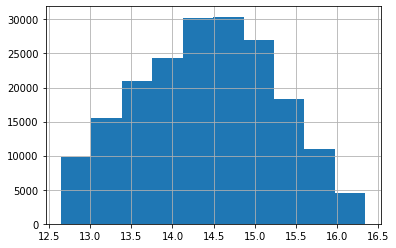

In [27]:
np.log(df_train_f['precio']).hist()

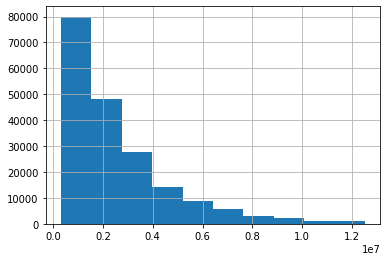

In [28]:
df_train_f['precio'].hist()